Ключевые моменты о бутстрэпе: Метод оценки статистических характеристик, основанный на многократных случайных выборках с возвратом из исходных данных.


Используется для оценки доверительных интервалов, стандартных ошибок и других статистик.
Не требует предположений о форме распределения данных.
Работает хорошо на небольших выборках.
Что важно учитывать: 

Размер выборки влияет на точность.
Количество бутстрэп-итераций должно быть достаточно большим (обычно 1000+).
Может быть чувствителен к выбросам и неустойчивым данным.
Примеры исполь
главный результат бутстрэпа — это доверительный интервал для оцениваемой статистики.зования: 

Оценка доверительных интервалов для среднего, медианы, разницы между группами.
Проверка устойчивости модели или статистики.

In [1]:
from scipy.stats import bootstrap
import pandas as pd
import numpy as np 
import seaborn as sns
import pingouin as pg

In [3]:
df = pd.read_csv('bootstrap_data.csv')

In [100]:
df.shape

(1254, 2)

In [5]:
df.head()

,value,group
0,100.719713,experimental
1,106.771525,experimental
2,106.974612,experimental
3,109.249662,experimental
4,116.230142,experimental


In [7]:
df.groupby('group').agg({'value': 'count'})

,value
group,
control,760
experimental,494


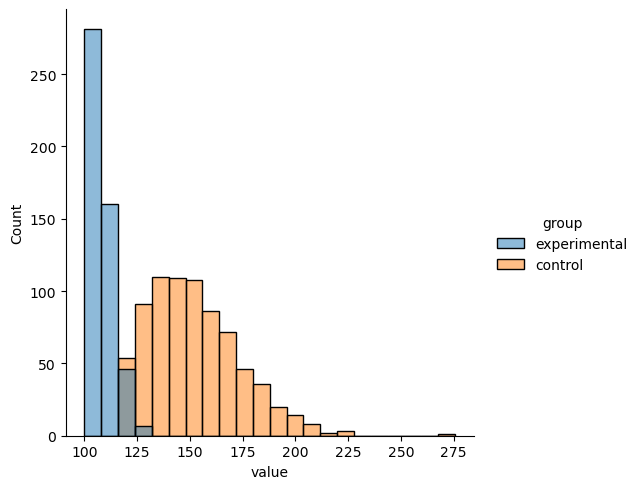

In [9]:
sns.displot(data=df, x="value", hue="group")

In [13]:
df.groupby('group').agg({'value': 'median'})

,value
group,
control,148.832127
experimental,106.982597


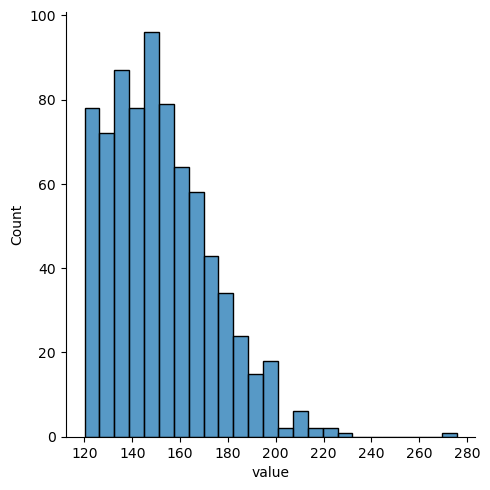

In [15]:
sns.displot(data=df[df.group == 'control'], x="value")

In [17]:
control_df = df[df.group == 'control']
experimental_df = df[df.group == 'experimental']

In [19]:
control_df.value.median()

148.83212650911054

In [21]:
medians = []

In [23]:
n = 10000

In [25]:
for i in range(10000):
    sample_data = control_df.sample(frac=1, replace=True)
    sample_median = sample_data.value.median()
    medians.append(sample_median)

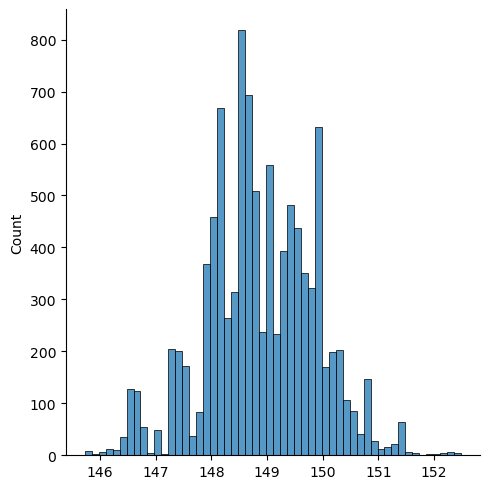

In [26]:
sns.displot(medians)

In [29]:
pd.Series(medians).quantile(0.975)

150.79195404716057

In [31]:
pd.Series(medians).quantile(0.025)

146.67710291645344

In [ ]:
#Непосредство использование встроенного Bootstrap

In [188]:
res = bootstrap((control_df.value, ), np.median, confidence_level=0.95, )

In [200]:
#Верная интерпритация данного бутсрэповского доверительного интервала:
#Если мы выполним выборку из исходного распределения 9999 раз и сформируем начальный доверительный интервал для каждой выборки,
#то доверительный интервал будет содержать истинное значение статистики примерно в 95% случаев.
print(f'{res.confidence_interval[0]} < {control_df.value.median()} <{res.confidence_interval[1]} ')

147.25097107944651 < 148.83212650911054 <150.39061867250206


In [35]:
bootstrap((experimental_df.value, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=106.2595922808035, high=107.79518591209785), bootstrap_distribution=array([106.88105394, 106.86645339, 107.26179619, ..., 106.92494121,
       107.47298392, 107.19669447]), standard_error=0.40882102525213737)

Доверительные интервалы медианных значений Контрольной и Экспериментальных групп не пересекаются даже близко, различия в данных значительны и значимы.

Так же с помощью библиотеки Pingouin

In [155]:
pg.compute_bootci(control_df.value, func='mean')

array([150.47, 153.64])

In [158]:
#Стандартное отклонение
pg.compute_bootci(control_df.value, func='std')

array([20.29, 22.98])

Увеличение размера выборки уменьшает ширину интервала, повышая точность оценки.
Более узкий интервал говорит о большей точности оценки исследуемого параметра.

In [39]:
bootstrap((control_df.value, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=150.50849914269597, high=153.56244821206516), bootstrap_distribution=array([152.82862348, 152.72750744, 152.31487377, ..., 152.70687021,
       151.6758884 , 152.01917774]), standard_error=0.7793070864610753)

In [54]:
bootstrap((control_df.value, ), n_resamples=100, statistic=np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=150.45092129973986, high=153.20005482468977), bootstrap_distribution=array([151.83831771, 151.67081131, 152.33321739, 152.15214797,
       150.45363747, 152.86743484, 151.8604331 , 151.25047212,
       150.89011194, 152.1683356 , 150.99448133, 151.94157581,
       152.59462894, 152.16107175, 152.62031981, 152.39972977,
       151.18743734, 152.83973799, 152.63199514, 150.78068622,
       150.99893091, 151.75490026, 152.99025456, 153.78453868,
       152.73824611, 152.08004283, 151.73351543, 152.59971755,
       151.88557849, 150.7759894 , 153.03777989, 153.20028608,
       152.57484316, 152.96699115, 152.90170342, 151.22277759,
       152.96984128, 152.14325933, 151.66389732, 151.10031052,
       153.81885302, 152.02749124, 152.1420159 , 152.27407788,
       151.5993607 , 153.02000496, 152.20855921, 150.3930524 ,
       152.03908284, 152.67004946, 152.09909297, 151.4557829 ,
       151.56911343, 152.16476469, 152.30939214, 152.

Смотрим на разницы средних подвыборок(бутстрапированных выборок), складываем эти значения в список и смотрим на распределение. Очень Важный критерий, чтобы полученный доверительный интервал не залезал на значение 0. В некотором смысле это говорит статзначимой разнице.

In [58]:

median_diff = []

for i in range(10000):
    sample_data_control = control_df.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.value.median()
    
    
    sample_data_exp = experimental_df.sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.value.median()
    
    sample_median_diff = sample_median_control - sample_median_exp
    median_diff.append(sample_median_diff)
    



In [60]:
pd.Series(median_diff).quantile(0.975)

43.90427518600858

In [62]:
pd.Series(median_diff).quantile(0.025)

39.59972636046745

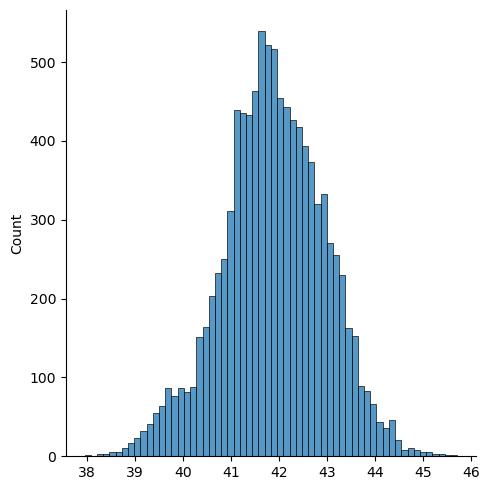

In [64]:
sns.displot(median_diff)

bootstrap также можно использовать для оценки доверительных интервалов статистики с несколькими выборками. Например, чтобы получить доверительный интервал для разницы между средними значениями, мы пишем функцию, которая принимает два аргумента выборки и возвращает только статистику. Использование аргумента axis гарантирует, что все вычисления среднего значения выполняются за один векторизованный вызов, что быстрее, чем перебор пар повторных выборок в Python. 
Вычислим разницу средих занчений нашей контрольной и эксперементальной групп 
control_df = df[df.group == 'control']
experimental_df = df[df.group == 'experimental']

In [312]:
control_gr = control_df.value.to_numpy()
exp_gr = experimental_df.value.to_numpy()

In [348]:
def stato(group_1, group_2, axis=1):
    return np.mean(group_1, axis=axis) - np.mean(group_2, axis=axis)
data = (control_gr, exp_gr)    

result = bootstrap(data, stato, confidence_level=0.9, n_resamples=500)

In [350]:
print(result.confidence_interval)

ConfidenceInterval(low=42.82579325916664, high=45.401456785984834)


In [352]:
goal = np.sum((result.bootstrap_distribution > result.confidence_interval[0]) & (result.bootstrap_distribution < result.confidence_interval[1]))

In [354]:
print(f'{goal/len(result.bootstrap_distribution)} - эмпирически полученный уровень значимости, при выставленном в bootstrap  confidence_level=0.9')

0.896 - эмпирически полученный уровень значимости, при выставленном в bootstrap  confidence_level=0.9
